<a href="https://colab.research.google.com/github/Mohamed-Diagne/AI-Driven-Real-Time-Crypto-Advisor/blob/main/AI_Driven_Crypto_Advisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI-Driven Real Time Crypto Advisor**

This project is designed to analyze and optimize a cryptocurrency portfolio by integrating multiple data sources and analytical techniques. It includes:

* **Data Collection:**  
  Retrieves historical price data and news articles for a predefined list of cryptocurrencies from sources like Binance and Yahoo Finance.

* **Technical Analysis:**  
  Computes various technical indicators (e.g., RSI, MACD, Bollinger Bands) on 5-minute data to evaluate market trends.

* **Sentiment Analysis:**  
  Uses TextBlob and DeepSeek (via Ollama) to analyze news summaries, providing AI-based sentiment scores and justifications for each crypto.

* **Portfolio Optimization:**  
  Applies Markowitz Sharpe ratio maximization and dynamic, rolling-window optimization to determine optimal asset allocations.

* **Visualization & Reporting:**  
  Creates visualizations (e.g., log return distributions, efficient frontier plots) to support decision-making.

* **Data Persistence:**  
  Merges and updates CSV files to maintain a historical record of combined data and latest insights.

Overall, the project combines technical signals, sentiment insights, and optimization techniques to inform better trading decisions in the crypto market.


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from binance.client import Client
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
import warnings
import time
import json
from tqdm.auto import tqdm
from ollama import chat
import concurrent.futures
from scipy import stats
import os

/Users/mohameddiagne/Desktop/Crypto/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Crypto Symbols & Mapping:

Defines a list of cryptocurrency symbols and creates a mapping to convert Binance symbols to Yahoo Finance format.

In [ ]:
CRYPTO_LIST = [
    "BTCUSDT",  # Bitcoin (BTC)
    "ETHUSDT",  # Ethereum (ETH)
    "SOLUSDT",  # Solana (SOL)
    "BNBUSDT",  # Binance Coin (BNB)
    "ADAUSDT",  # Cardano (ADA)
    "DOTUSDT",  # Polkadot (DOT)
    "AVAXUSDT", # Avalanche (AVAX)
    "DOGEUSDT", # Dogecoin (DOGE)
    "SHIBUSDT", # Shiba Inu (SHIB)
    "LTCUSDT",  # Litecoin (LTC)
    "LINKUSDT", # Chainlink (LINK)
    "MATICUSDT",# Polygon (MATIC)
    "XLMUSDT",  # Stellar Lumens (XLM)
    "VETUSDT",  # VeChain (VET)
    "TRXUSDT",  # TRON (TRX)
    "FILUSDT",  # Filecoin (FIL)
    "ICPUSDT",  # Internet Computer (ICP)
    "ATOMUSDT", # Cosmos (ATOM)
    "XTZUSDT",  # Tezos (XTZ)
    "ALGOUSDT", # Algorand (ALGO)
    "LTCUSDT",  # Litecoin (LTC)
    "LINKUSDT", # Chainlink (LINK)
    "MATICUSDT",# Polygon (MATIC)
    "XLMUSDT",  # Stellar Lumens (XLM)
    "XTZUSDT",  # Tezos (XTZ)
    "ALGOUSDT"  # Algorand (ALGO)
]
YFINANCE_MAPPING = {symbol: symbol.replace("USDT", "-USD") for symbol in CRYPTO_LIST}



## Binance API Connection:
Sets API keys, attempts to connect to Binance using the API client, and handles connection errors.

In [ ]:

api_keys = {"": "", "": ""}
print("Tentative de connexion à Binance...")
try:
    binance_client = Client(api_keys[""], api_keys[""], tld='com')
    print(" Connexion réussie à Binance.")
except Exception as e:
    print(f"Erreur de connexion : {e}")
    binance_client = None

Tentative de connexion à Binance...
 Connexion réussie à Binance.


## Fetch and Aggregate 5-Minute Candlestick Data
* Retrieves historical candlestick data for each cryptocurrency symbol over the past week with a 5-minute interval using the Binance API.
* Converts raw API response into a pandas DataFrame, ensuring numerical conversion for the 'Close' column and datetime conversion for the 'Open time'.
* Inserts the corresponding symbol as a new column in the DataFrame.
Utilizes a ThreadPoolExecutor with a maximum of 5 workers to concurrently fetch data for all symbols in the CRYPTO_LIST.
* Aggregates all individual DataFrames into a single combined DataFrame and displays the final result.
* Handles errors gracefully by printing messages and skipping symbols with missing data.

In [ ]:
def fetch_symbol_data(symbol):
    print(f"Récupération des bougies de 5 minutes pour {symbol} sur 1 semaine...")
    try:
        # Récupérer les données pour 1 semaine avec un intervalle de 5 minutes
        klines = binance_client.get_historical_klines(symbol, "5m", "1 week ago UTC")
        if not klines:
            print(f"Aucune donnée récupérée pour {symbol}.")
            return None

        df = pd.DataFrame(
            klines,
            columns=["Open time", "Open", "High", "Low", "Close", "Volume",
                     "Close time", "Quote asset volume", "Number of trades",
                     "Taker buy base asset volume", "Taker buy quote asset volume", "Ignore"]
        )
        df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
        df["Open time"] = pd.to_datetime(df["Open time"], unit="ms")

        # Ajouter la colonne 'Symbol'
        df.insert(0, "Symbol", symbol)
        return df
    except Exception as e:
        print(f"Erreur lors de la récupération pour {symbol} : {e}")
        return None

data_list = []
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(fetch_symbol_data, symbol): symbol for symbol in CRYPTO_LIST}
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            data_list.append(result)

if data_list:
    combined_df = pd.concat(data_list, ignore_index=True)
    print("\nDonnées combinées des bougies de 5 minutes pour chaque crypto sur 1 semaine :")
    display(combined_df)
else:
    print("Aucune donnée récupérée pour aucune crypto.")


Récupération des bougies de 5 minutes pour BTCUSDT sur 1 semaine...Récupération des bougies de 5 minutes pour ETHUSDT sur 1 semaine...

Récupération des bougies de 5 minutes pour SOLUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour BNBUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour ADAUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour DOTUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour AVAXUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour DOGEUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour SHIBUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour LTCUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour LINKUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour MATICUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour XLMUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour VETUSDT sur 1 semaine...
Récupération des bougies de 5 minutes pour

,Symbol,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,ETHUSDT,2025-03-09 09:55:00,2168.80000000,2168.80000000,2160.92000000,2165.7900,2253.08540000,1741514399999,4876486.25692400,11795,942.00130000,2038649.57757600,0
1,ETHUSDT,2025-03-09 10:00:00,2165.80000000,2166.70000000,2163.00000000,2165.0500,1379.31240000,1741514699999,2985831.49130800,8586,709.45130000,1535792.83776900,0
2,ETHUSDT,2025-03-09 10:05:00,2165.05000000,2170.30000000,2162.56000000,2162.9000,817.31330000,1741514999999,1771974.33109600,7641,394.95540000,856394.41537600,0
3,ETHUSDT,2025-03-09 10:10:00,2162.91000000,2166.10000000,2161.67000000,2165.5000,736.47400000,1741515299999,1594066.20442500,6103,249.86110000,540820.81669500,0
4,ETHUSDT,2025-03-09 10:15:00,2165.50000000,2167.70000000,2157.72000000,2159.5200,1321.80840000,1741515599999,2856838.67510300,7893,312.86040000,676508.53518500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48379,ALGOUSDT,2025-03-16 09:30:00,0.19690000,0.19730000,0.19630000,0.1965,141172.00000000,1742117699999,27782.18410000,369,85780.00000000,16890.16350000,0
48380,ALGOUSDT,2025-03-16 09:35:00,0.19650000,0.19660000,0.19510000,0.1955,366278.00000000,1742117999999,71679.72880000,600,95971.00000000,18786.81050000,0
48381,ALGOUSDT,2025-03-16 09:40:00,0.19550000,0.19550000,0.19450000,0.1948,629119.00000000,1742118299999,122614.94950000,855,120883.00000000,23556.66890000,0
48382,ALGOUSDT,2025-03-16 09:45:00,0.19480000,0.19540000,0.19480000,0.1954,157389.00000000,1742118599999,30710.58240000,436,77784.00000000,15178.28980000,0


# Compute Technical Indicators

* **DataFrame Usage:**  
  Uses the existing `combined_df` containing historical 5-minute candle data for each crypto.

* **Grouping by Symbol:**  
  Groups `combined_df` by the "Symbol" column to process each crypto separately.

* **Data Conversion & Sorting:**  
  For each group, the `calc_indicators` function converts "Close" and "Volume" to numeric types, "Open time" to datetime, and sorts the data by time.

* **Moving Averages Calculation:**  
  Computes simple moving averages (SMA10, SMA20) and exponential moving averages (EMA10, EMA20).

* **RSI Calculation:**  
  Calculates the 14-period RSI using price differences, average gains, and losses.

* **MACD Calculation:**  
  Derives EMA12 and EMA26, then computes the MACD line, Signal line, and MACD Histogram.

* **Bollinger Bands:**  
  Generates Bollinger Bands using a 20-period moving average and standard deviation to form upper and lower bands.

* **Stochastic Oscillator:**  
  Computes %K by finding the 14-period lowest and highest prices, and calculates %D as a 3-period moving average of %K.

* **OBV Calculation:**  
  Calculates On Balance Volume (OBV) based on price change signs and cumulative volume.

In [ ]:
def calc_indicators(df):

    # Assurer que les données sont triées par date
    df = df.sort_values("Open time").copy()

    # Conversion des colonnes essentielles
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

    # Moyennes mobiles
    df["SMA10"] = df["Close"].rolling(window=10).mean()
    df["SMA20"] = df["Close"].rolling(window=20).mean()
    df["EMA10"] = df["Close"].ewm(span=10, adjust=False).mean()
    df["EMA20"] = df["Close"].ewm(span=20, adjust=False).mean()

    # RSI (14 périodes)
    delta = df["Close"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # MACD
    df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = df["EMA12"] - df["EMA26"]
    df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
    df["MACD_Hist"] = df["MACD"] - df["Signal"]

    # Bandes de Bollinger (période 20, écart-type = 2)
    df["BB_Middle"] = df["Close"].rolling(window=20).mean()
    df["BB_STD"] = df["Close"].rolling(window=20).std()
    df["BB_Upper"] = df["BB_Middle"] + 2 * df["BB_STD"]
    df["BB_Lower"] = df["BB_Middle"] - 2 * df["BB_STD"]

    # Oscillateur stochastique (période 14, %D sur 3 périodes)
    df["Lowest14"] = df["Low"].rolling(window=14).min()
    df["Highest14"] = df["High"].rolling(window=14).max()
    df["Stoch_K"] = ((df["Close"] - df["Lowest14"]) / (df["Highest14"] - df["Lowest14"])) * 100
    df["Stoch_D"] = df["Stoch_K"].rolling(window=3).mean()

    # On Balance Volume (OBV)
    df["direction"] = np.sign(df["Close"].diff())
    df["OBV"] = (df["direction"] * df["Volume"]).fillna(0).cumsum()

    # Récupérer la dernière ligne (les indicateurs les plus récents)
    last_row = df.iloc[-1]
    return {
        "Symbol": df["Symbol"].iloc[0],
        "SMA10": last_row["SMA10"],
        "SMA20": last_row["SMA20"],
        "EMA10": last_row["EMA10"],
        "EMA20": last_row["EMA20"],
        "RSI": last_row["RSI"],
        "MACD": last_row["MACD"],
        "Signal": last_row["Signal"],
        "MACD_Hist": last_row["MACD_Hist"],
        "BB_Middle": last_row["BB_Middle"],
        "BB_Upper": last_row["BB_Upper"],
        "BB_Lower": last_row["BB_Lower"],
        "Stoch_K": last_row["Stoch_K"],
        "Stoch_D": last_row["Stoch_D"],
        "OBV": last_row["OBV"]
    }

# Vérifier que combined_df existe et contient toutes les données nécessaires
if 'combined_df' in globals() and not combined_df.empty:
    indicators_list = []
    # Calculer les indicateurs pour chaque crypto en groupant par 'Symbol'
    for symbol, group in combined_df.groupby("Symbol"):
        try:
            indicators = calc_indicators(group)
            indicators_list.append(indicators)
        except Exception as e:
            print(f"Erreur lors du calcul des indicateurs pour {symbol} : {e}")

    if indicators_list:
        indicators_df = pd.DataFrame(indicators_list)
        # Fusionner les indicateurs avec le DataFrame existant sur la colonne 'Symbol'
        combined_df = combined_df.merge(indicators_df, on="Symbol", how="left")
        print("\nDataFrame final avec les indicateurs techniques ajoutés :")
        display(combined_df)
    else:
        print("Aucun indicateur technique n'a été calculé.")
else:
    print("combined_df n'existe pas ou est vide.")



DataFrame final avec les indicateurs techniques ajoutés :


,Symbol,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,...,RSI,MACD,Signal,MACD_Hist,BB_Middle,BB_Upper,BB_Lower,Stoch_K,Stoch_D,OBV
0,ETHUSDT,2025-03-09 09:55:00,2168.80000000,2168.80000000,2160.92000000,2165.7900,2253.08540000,1741514399999,4876486.25692400,11795,...,29.996524,-3.904678,-2.826471,-1.078207,1918.114500,1927.888988,1908.340012,21.248631,19.532676,-3.576363e+05
1,ETHUSDT,2025-03-09 10:00:00,2165.80000000,2166.70000000,2163.00000000,2165.0500,1379.31240000,1741514699999,2985831.49130800,8586,...,29.996524,-3.904678,-2.826471,-1.078207,1918.114500,1927.888988,1908.340012,21.248631,19.532676,-3.576363e+05
2,ETHUSDT,2025-03-09 10:05:00,2165.05000000,2170.30000000,2162.56000000,2162.9000,817.31330000,1741514999999,1771974.33109600,7641,...,29.996524,-3.904678,-2.826471,-1.078207,1918.114500,1927.888988,1908.340012,21.248631,19.532676,-3.576363e+05
3,ETHUSDT,2025-03-09 10:10:00,2162.91000000,2166.10000000,2161.67000000,2165.5000,736.47400000,1741515299999,1594066.20442500,6103,...,29.996524,-3.904678,-2.826471,-1.078207,1918.114500,1927.888988,1908.340012,21.248631,19.532676,-3.576363e+05
4,ETHUSDT,2025-03-09 10:15:00,2165.50000000,2167.70000000,2157.72000000,2159.5200,1321.80840000,1741515599999,2856838.67510300,7893,...,29.996524,-3.904678,-2.826471,-1.078207,1918.114500,1927.888988,1908.340012,21.248631,19.532676,-3.576363e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48379,ALGOUSDT,2025-03-16 09:30:00,0.19690000,0.19730000,0.19630000,0.1965,141172.00000000,1742117699999,27782.18410000,369,...,20.000000,-0.000846,-0.000760,-0.000087,0.196405,0.198612,0.194198,21.428571,20.476190,-1.678290e+07
48380,ALGOUSDT,2025-03-16 09:35:00,0.19650000,0.19660000,0.19510000,0.1955,366278.00000000,1742117999999,71679.72880000,600,...,20.000000,-0.000846,-0.000760,-0.000087,0.196405,0.198612,0.194198,21.428571,20.476190,-1.678290e+07
48381,ALGOUSDT,2025-03-16 09:40:00,0.19550000,0.19550000,0.19450000,0.1948,629119.00000000,1742118299999,122614.94950000,855,...,20.000000,-0.000846,-0.000760,-0.000087,0.196405,0.198612,0.194198,21.428571,20.476190,-1.678290e+07
48382,ALGOUSDT,2025-03-16 09:45:00,0.19480000,0.19540000,0.19480000,0.1954,157389.00000000,1742118599999,30710.58240000,436,...,20.000000,-0.000846,-0.000760,-0.000087,0.196405,0.198612,0.194198,21.428571,20.476190,-1.678290e+07


# Visualization of Technical Indicators (5m Data)

* **RSI:** Bar plot per symbol with overbought (70) and oversold (30) thresholds.
* **MACD Histogram:** Bar plot displaying MACD histogram values.
* **OBV:** Bar plot of On Balance Volume for each crypto.
* **Bollinger Bands:** Bar plot (using melted data) showing BB Middle, Upper, and Lower values.
* **Stochastic Oscillator:** Bar plot of %K and %D values.
* **Annotation:** Text panel indicating that indicators are recalculated on 5m data.


/var/folders/vm/ckx__j2j2352p4bt45rsgd040000gn/T/ipykernel_7747/389669240.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x="Symbol", y="RSI", data=combined_df, palette="viridis")
/var/folders/vm/ckx__j2j2352p4bt45rsgd040000gn/T/ipykernel_7747/389669240.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x="Symbol", y="MACD_Hist", data=combined_df, palette="coolwarm")
/var/folders/vm/ckx__j2j2352p4bt45rsgd040000gn/T/ipykernel_7747/389669240.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x="Symbol", y="OBV", da

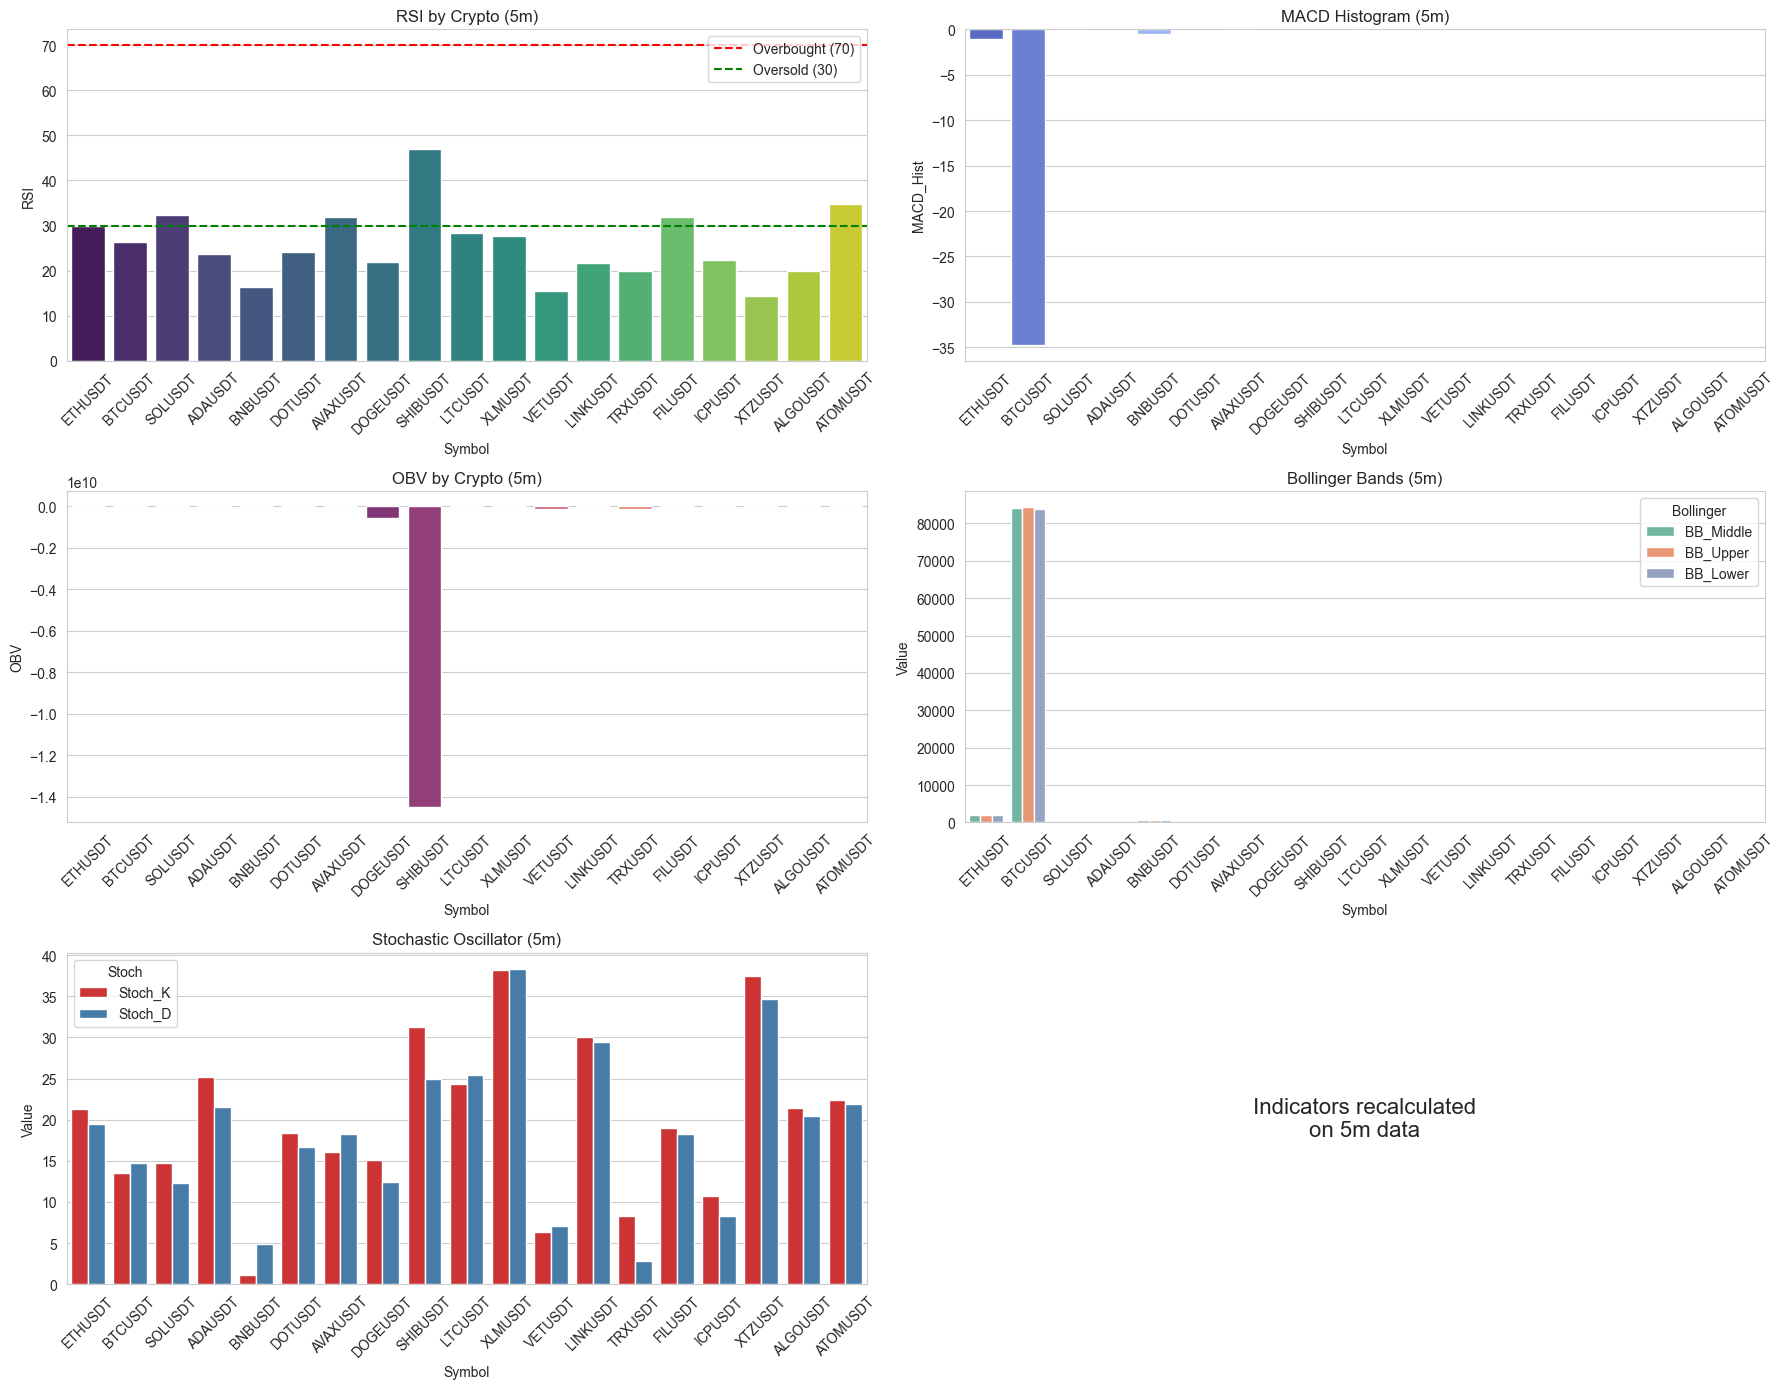

In [ ]:
# Set seaborn style and create subplots
sns.set_style("whitegrid")
fig, axs = plt.subplots(3, 2, figsize=(18, 14))

# * RSI Plot
ax = axs[0, 0]
sns.barplot(ax=ax, x="Symbol", y="RSI", data=combined_df, palette="viridis")
ax.axhline(70, color="red", linestyle="--", label="Overbought (70)")
ax.axhline(30, color="green", linestyle="--", label="Oversold (30)")
ax.set(title="RSI by Crypto (5m)", xlabel="Symbol", ylabel="RSI")
ax.legend()
ax.tick_params(axis="x", rotation=45)

# * MACD Histogram
ax = axs[0, 1]
sns.barplot(ax=ax, x="Symbol", y="MACD_Hist", data=combined_df, palette="coolwarm")
ax.set(title="MACD Histogram (5m)", xlabel="Symbol", ylabel="MACD_Hist")
ax.tick_params(axis="x", rotation=45)

# * OBV Plot
ax = axs[1, 0]
sns.barplot(ax=ax, x="Symbol", y="OBV", data=combined_df, palette="magma")
ax.set(title="OBV by Crypto (5m)", xlabel="Symbol", ylabel="OBV")
ax.tick_params(axis="x", rotation=45)

# * Bollinger Bands
bb_data = combined_df.melt(
    id_vars=["Symbol"],
    value_vars=["BB_Middle", "BB_Upper", "BB_Lower"],
    var_name="Bollinger",
    value_name="Value"
)
ax = axs[1, 1]
sns.barplot(ax=ax, x="Symbol", y="Value", hue="Bollinger", data=bb_data, palette="Set2")
ax.set(title="Bollinger Bands (5m)", xlabel="Symbol", ylabel="Value")
ax.legend(title="Bollinger")
ax.tick_params(axis="x", rotation=45)

# * Stochastic Oscillator
stoch_data = combined_df.melt(
    id_vars=["Symbol"],
    value_vars=["Stoch_K", "Stoch_D"],
    var_name="Stoch",
    value_name="Value"
)
ax = axs[2, 0]
sns.barplot(ax=ax, x="Symbol", y="Value", hue="Stoch", data=stoch_data, palette="Set1")
ax.set(title="Stochastic Oscillator (5m)", xlabel="Symbol", ylabel="Value")
ax.legend(title="Stoch")
ax.tick_params(axis="x", rotation=45)

# * Annotation subplot
ax = axs[2, 1]
ax.axis("off")
ax.text(0.5, 0.5, "Indicators recalculated\non 5m data",
        ha="center", va="center", fontsize=16,
        bbox=dict(facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()


# Crypto News and Sentiment Analysis

* Retrieves the latest news for each crypto symbol from yfinance.
* Uses an existing CRYPTO_LIST and converts Binance symbols (USDT) to yfinance format (-USD).
* Calculates sentiment scores using TextBlob based on the news title and summary.
* Aggregates results into a DataFrame and merges with combined_df if it exists.

In [ ]:
# CRYPTO_LIST est déjà défini précédemment

# Mapping pour yfinance (remplace "USDT" par "-USD")
YFINANCE_MAPPING = {symbol: symbol.replace("USDT", "-USD") for symbol in CRYPTO_LIST}

def get_crypto_news():
    """
    Récupère la dernière actualité pour chaque crypto de CRYPTO_LIST via yfinance,
    calcule le sentiment avec TextBlob et renvoie un DataFrame.
    """
    all_news = []
    for symbol in CRYPTO_LIST:
        yfinance_symbol = YFINANCE_MAPPING.get(symbol, symbol)
        try:
            news = yf.Ticker(yfinance_symbol).news
            if news and isinstance(news, list) and len(news) > 0 and news[0]:
                latest = news[0]
                content = latest.get("content", {})
                title = content.get("title", "N/A")
                # Utilise 'summary', sinon fallback sur 'description'
                summary = content.get("summary") or content.get("description", "N/A")
                pubDate = content.get("pubDate", "N/A")
                click_data = content.get("clickThroughUrl")
                url = click_data.get("url", "N/A") if isinstance(click_data, dict) else "N/A"
                sentiment_score = round(TextBlob(f"{title} {summary}").sentiment.polarity, 2)
                sentiment = "Positif" if sentiment_score > 0 else "Négatif" if sentiment_score < 0 else "Neutre"
                all_news.append({
                    "Symbol": symbol,
                    "News_Title": title,
                    "News_Summary": summary,
                    "News_pubDate": pubDate,
                    "News_URL": url,
                    "sentiment_score_tb": sentiment_score,
                    "sentiment_tb": sentiment
                })
            else:
                print(f"Aucune news valide pour {symbol} (yfinance: {yfinance_symbol}).")
        except Exception as e:
            print(f"Erreur pour {symbol} (yfinance: {yfinance_symbol}) : {e}")
            continue
    return pd.DataFrame(all_news) if all_news else pd.DataFrame()

# Récupération des actualités
news_df = get_crypto_news()

# Affichage du nombre de valeurs manquantes dans la colonne 'News_Summary'
missing_count = news_df['News_Summary'].isna().sum()
print(f"Nombre de valeurs manquantes dans 'News_Summary': {missing_count}")

# Fusion avec le DataFrame existant (combined_df)
if not news_df.empty:
    combined_df = combined_df.merge(news_df, on="Symbol", how="left")
    print("DataFrame final après fusion avec les actualités :")
    display(combined_df)
else:
    print("Aucune actualité n'a été récupérée.")


Aucune news valide pour DOTUSDT (yfinance: DOT-USD).
Aucune news valide pour ATOMUSDT (yfinance: ATOM-USD).
Aucune news valide pour XTZUSDT (yfinance: XTZ-USD).
Aucune news valide pour XTZUSDT (yfinance: XTZ-USD).
Nombre de valeurs manquantes dans 'News_Summary': 0
DataFrame final après fusion avec les actualités :


,Symbol,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,...,BB_Lower,Stoch_K,Stoch_D,OBV,News_Title,News_Summary,News_pubDate,News_URL,sentiment_score_tb,sentiment_tb
0,ETHUSDT,2025-03-09 09:55:00,2168.80000000,2168.80000000,2160.92000000,2165.7900,2253.08540000,1741514399999,4876486.25692400,11795,...,1908.340012,21.248631,19.532676,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre
1,ETHUSDT,2025-03-09 10:00:00,2165.80000000,2166.70000000,2163.00000000,2165.0500,1379.31240000,1741514699999,2985831.49130800,8586,...,1908.340012,21.248631,19.532676,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre
2,ETHUSDT,2025-03-09 10:05:00,2165.05000000,2170.30000000,2162.56000000,2162.9000,817.31330000,1741514999999,1771974.33109600,7641,...,1908.340012,21.248631,19.532676,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre
3,ETHUSDT,2025-03-09 10:10:00,2162.91000000,2166.10000000,2161.67000000,2165.5000,736.47400000,1741515299999,1594066.20442500,6103,...,1908.340012,21.248631,19.532676,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre
4,ETHUSDT,2025-03-09 10:15:00,2165.50000000,2167.70000000,2157.72000000,2159.5200,1321.80840000,1741515599999,2856838.67510300,7893,...,1908.340012,21.248631,19.532676,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64507,ALGOUSDT,2025-03-16 09:40:00,0.19550000,0.19550000,0.19450000,0.1948,629119.00000000,1742118299999,122614.94950000,855,...,0.194198,21.428571,20.476190,-1.678290e+07,Young Money: 4 Cryptos Perfect for Millennial ...,Buying cryptos for millennial and Gen-Z invest...,2024-03-21T20:30:00Z,https://finance.yahoo.com/news/young-money-4-c...,0.18,Positif
64508,ALGOUSDT,2025-03-16 09:45:00,0.19480000,0.19540000,0.19480000,0.1954,157389.00000000,1742118599999,30710.58240000,436,...,0.194198,21.428571,20.476190,-1.678290e+07,Young Money: 4 Cryptos Perfect for Millennial ...,Buying cryptos for millennial and Gen-Z invest...,2024-03-21T20:30:00Z,https://finance.yahoo.com/news/young-money-4-c...,0.18,Positif
64509,ALGOUSDT,2025-03-16 09:45:00,0.19480000,0.19540000,0.19480000,0.1954,157389.00000000,1742118599999,30710.58240000,436,...,0.194198,21.428571,20.476190,-1.678290e+07,Young Money: 4 Cryptos Perfect for Millennial ...,Buying cryptos for millennial and Gen-Z invest...,2024-03-21T20:30:00Z,https://finance.yahoo.com/news/young-money-4-c...,0.18,Positif
64510,ALGOUSDT,2025-03-16 09:50:00,0.19540000,0.19540000,0.19490000,0.1951,57989.00000000,1742118899999,11314.09720000,192,...,0.194198,21.428571,20.476190,-1.678290e+07,Young Money: 4 Cryptos Perfect for Millennial ...,Buying cryptos for millennial and Gen-Z invest...,2024-03-21T20:30:00Z,https://finance.yahoo.com/news/young-money-4-c...,0.18,Positif


# Analyse de Sentiment et Action Trading (DeepSeek Ollama)

* **get_sentiment_from_summary:** Envoie un résumé de news à DeepSeek via Ollama pour obtenir un sentiment (Positif/Neutre/Négatif) et une justification brève.
* **get_action_from_technical:** Détermine l'action de trading basée sur le RSI (SELL si RSI > 70, BUY si RSI < 30, sinon HOLD).
* **analyze_row_AI:** Combine le RSI et le résumé de news pour créer un prompt d'analyse.
* Le code filtre `combined_df` pour récupérer la dernière bougie (5m) par crypto, applique les fonctions d'analyse, et affiche le DataFrame final.

In [ ]:
def get_sentiment_from_summary(summary):
    prompt = (
        f"Analyze the following crypto news summary and determine the trading potential "
        f"of this crypto for my portfolio. Consider whether it is promising or not. "
        "Return strictly in the following format:\n"
        "sentiment_IA: <Positif/Neutre/Négatif>\n"
        "justification_IA: <brief justification in 10 words max>\n"
        "Do not include any extra commentary or symbols.\n\n"
        f"News Summary: {summary}"
    )
    response = chat(model="deepseek-r1:1.5b", messages=[{"role": "user", "content": prompt}])
    content = response.get("message", {}).get("content", "").strip()
    sentiment, justification = "Neutre", ""
    for line in content.splitlines():
        if line.lower().startswith("sentiment_ia:"):
            sentiment = line.split(":", 1)[1].strip().capitalize()
        elif line.lower().startswith("justification_ia:"):
            justification = line.split(":", 1)[1].strip()
    return sentiment, justification

def get_action_from_technical(row):
    try:
        rsi = float(row.get("RSI", 50))
    except Exception:
        rsi = 50.0
    return "SELL" if rsi > 70 else "BUY" if rsi < 30 else "HOLD"

def analyze_row_AI(row):
    text = f"RSI: {row.get('RSI', 'N/A')}\nNews Summary: {row.get('News_Summary', 'N/A')}"
    return get_sentiment_from_summary(text)

# Filtrer combined_df pour obtenir la dernière bougie (5m) par crypto
latest_df = combined_df.sort_values("Open time").groupby("Symbol").tail(1).copy()

# Appliquer l'analyse IA sur chaque ligne pour obtenir sentiment et justification
latest_df["sentiment_IA"], latest_df["justification_IA"] = zip(*latest_df.apply(analyze_row_AI, axis=1))
latest_df["action_IA"] = latest_df.apply(get_action_from_technical, axis=1)

print("Analyse de sentiment et action (DeepSeek Ollama) pour la dernière bougie (5m) par crypto:")
display(latest_df)


Analyse de sentiment et action (DeepSeek Ollama) pour la dernière bougie (5m) par crypto:


,Symbol,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,...,OBV,News_Title,News_Summary,News_pubDate,News_URL,sentiment_score_tb,sentiment_tb,sentiment_IA,justification_IA,action_IA
2015,ETHUSDT,2025-03-16 09:50:00,1910.45000000,1910.46000000,1908.00000000,1909.110000,492.66210000,1742118899999,940565.41052800,3091,...,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre,Bearish,Easing US inflation and institutional interest...,BUY
4031,BTCUSDT,2025-03-16 09:50:00,83936.70000000,83936.71000000,83855.76000000,83865.810000,15.74783000,1742118899999,1320906.92864010,4654,...,-1.083710e+04,Don't invest in crypto if you can't handle '30...,Cryptocurrency experienced significant volatil...,2025-03-14T19:17:45Z,https://finance.yahoo.com/video/dont-invest-cr...,0.19,Positif,Neutre,,BUY
6047,SOLUSDT,2025-03-16 09:50:00,133.56000000,133.62000000,133.37000000,133.470000,5249.58800000,1742118899999,700816.53756000,3604,...,-1.591113e+06,"Will bitcoin hit $125,000 this year? Yahoo Fin...","Bitcoin rallied at the start of the week, afte...",2025-03-07T15:32:05Z,https://finance.yahoo.com/news/bitcoin-price-c...,0.50,Positif,Neutre,Bitcoin may signal upward momentum due to Trum...,HOLD
8063,ADAUSDT,2025-03-16 09:50:00,0.72800000,0.72900000,0.72700000,0.727700,1035287.60000000,1742118899999,753818.13308000,1512,...,-5.516417e+07,David Sacks says the US may have lost over $16...,Trump's executive order launching a Strategic ...,2025-03-09T03:32:23Z,https://finance.yahoo.com/news/david-sacks-say...,0.10,Positif,Positif,The announcement of a Strategic Bitcoin Reserv...,BUY
10079,BNBUSDT,2025-03-16 09:50:00,602.23000000,602.29000000,601.27000000,601.340000,975.62900000,1742118899999,586969.69845000,1773,...,8.466853e+04,Crypto party: The SEC dropping a major lawsuit...,"""This is not about how the litigation was goin...",2025-02-21T17:56:35Z,https://finance.yahoo.com/news/crypto-party-se...,0.12,Positif,Neutre,,BUY
12095,DOTUSDT,2025-03-16 09:50:00,4.27600000,4.27700000,4.26800000,4.271000,8144.80000000,1742118899999,34798.96398000,171,...,-1.489256e+06,NaN,NaN,NaN,NaN,NaN,NaN,Neutre,The provided information includes an incomplet...,BUY
14111,AVAXUSDT,2025-03-16 09:50:00,19.12000000,19.12000000,19.06000000,19.080000,2111.59000000,1742118899999,40286.63610000,256,...,3.350007e+05,Caution: 3 Meme Coins on the Verge of a Major ...,"Meme coins are rallying again, mirroring the b...",2024-03-18T17:40:07Z,https://finance.yahoo.com/news/caution-3-meme-...,0.12,Positif,Neutre,Meme coins offer speculative potential but lac...,HOLD
16127,DOGEUSDT,2025-03-16 09:50:00,0.17219000,0.17224000,0.17185000,0.172080,1868943.00000000,1742118899999,321544.52293000,1697,...,-5.903226e+08,What to expect from the White House's crypto s...,US President Donald Trump is set to hold a cry...,2025-03-07T11:00:44Z,https://finance.yahoo.com/video/expect-white-h...,0.16,Positif,Negative,The positive elements such as Trump's involvem...,BUY
18143,SHIBUSDT,2025-03-16 09:50:00,0.00001299,0.00001299,0.00001296,0.000013,2137175848.00,1742118899999,27723.01001428,3521,...,-1.450384e+10,What to expect from the White House's crypto s...,US President Donald Trump is set to hold a cry...,2025-03-07T11:00:44Z,https://finance.yahoo.com/video/expect-white-h...,0.16,Positif,3/10,The news suggests an overbought condition in c...,HOLD
60479,XLMUSDT,2025-03-16 09:50:00,0.27020000,0.27020000,0.26950000,0.269800,28892.00000000,1742118899999,7793.35460000,244,...,-7.826049e+06,"Koreans Go Full Monty on DOGE, XRP, XLM After ...","DOGE, XRP and XLM are the most traded cryptocu...",2024-11-25T08:36:46Z,https://finance.yahoo.com/news/koreans-full-mo...,0.54,Positif,Positif,"RSI is below 30, indicating bearish conditions...",BUY


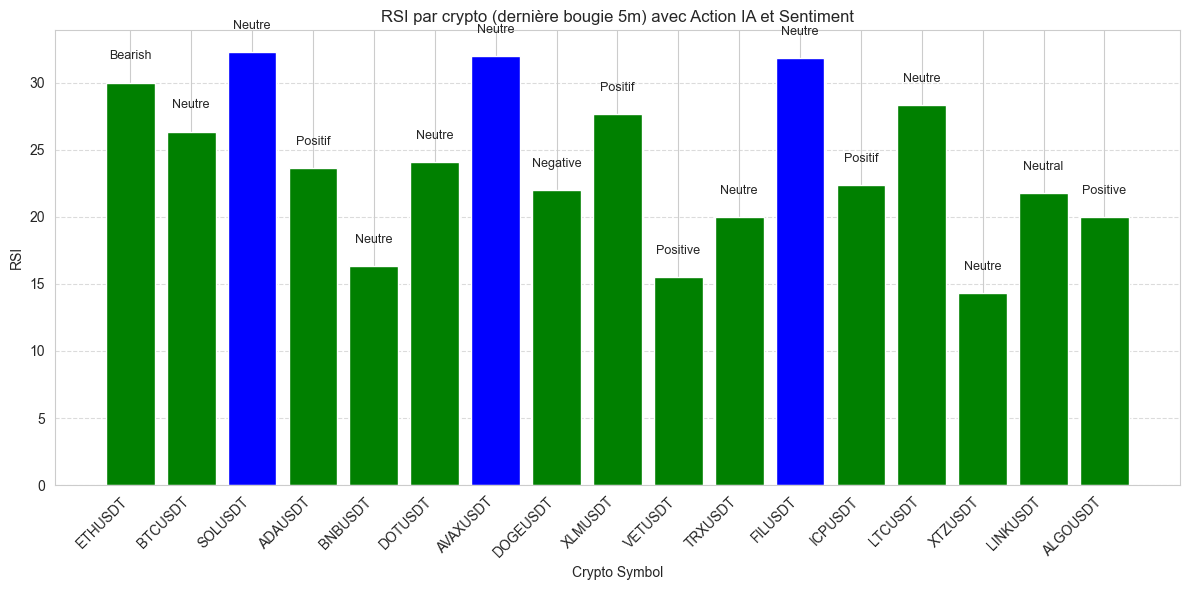

In [ ]:
import matplotlib.pyplot as plt

# 1. Filtrer les cryptos à exclure
exclude_symbols = ["ATOMUSDT", "SHIBUSDT"]
filtered_df = latest_df[~latest_df["Symbol"].isin(exclude_symbols)].copy()

def action_color(action):
    if action.upper() == "BUY":
        return "green"
    elif action.upper() == "SELL":
        return "red"
    else:
        return "blue"

# Extraire les données nécessaires depuis le DataFrame filtré
symbols = filtered_df["Symbol"]
rsi_values = filtered_df["RSI"].fillna(0)
actions = filtered_df["action_IA"].fillna("Na")
sentiments = filtered_df["sentiment_IA"].fillna("N/A")

colors = [action_color(a) for a in actions]

plt.figure(figsize=(12, 6))
bars = plt.bar(symbols, rsi_values, color=colors)

plt.xlabel("Crypto Symbol")
plt.ylabel("RSI")
plt.title("RSI par crypto (dernière bougie 5m) avec Action IA et Sentiment")

plt.xticks(rotation=45, ha='right')

for bar, sentiment in zip(bars, sentiments):
    height = bar.get_height()
    offset = 1.5
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + offset,
        sentiment,
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


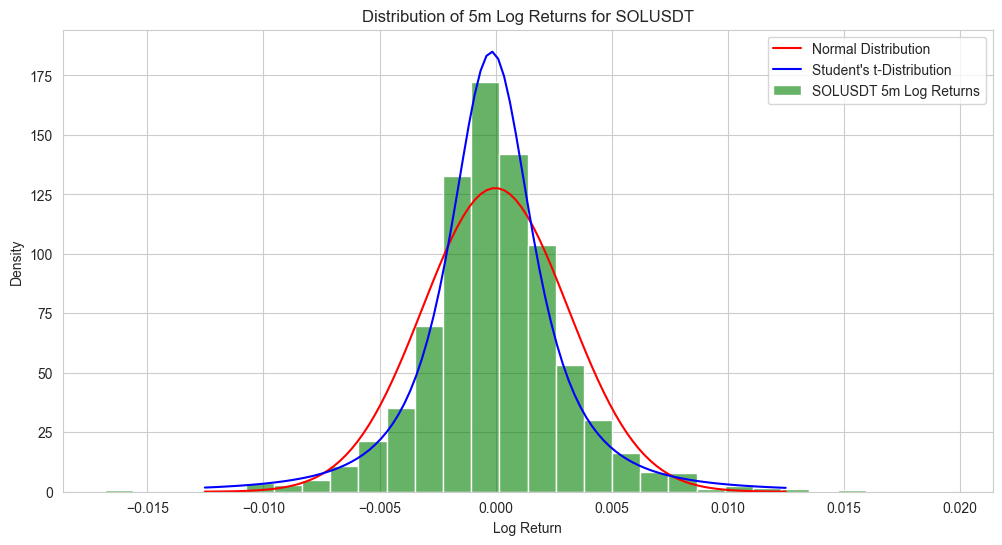

SOLUSDT: normaltest stat = 200.38, p-value = 0.000
=> Distribution significantly differs from a normal distribution.



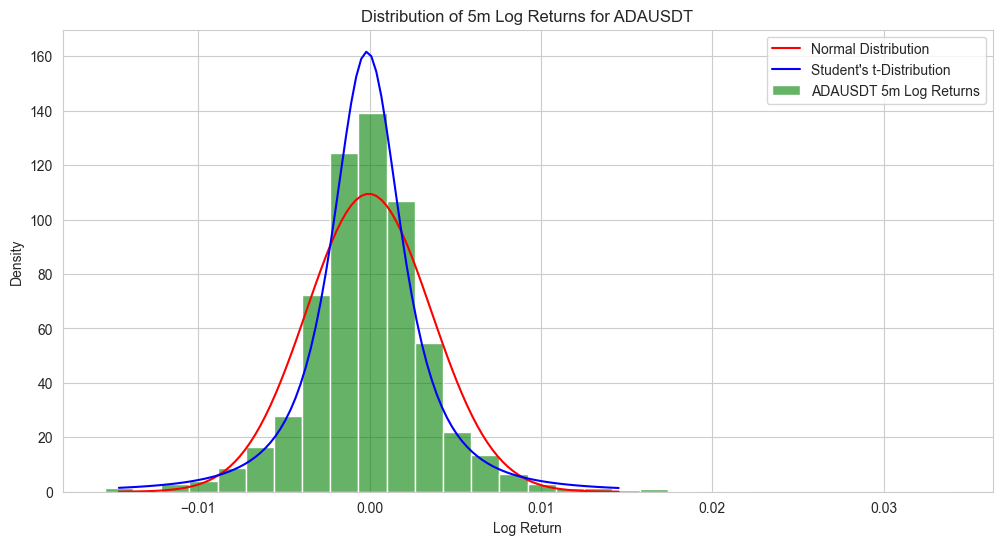

ADAUSDT: normaltest stat = 398.13, p-value = 0.000
=> Distribution significantly differs from a normal distribution.



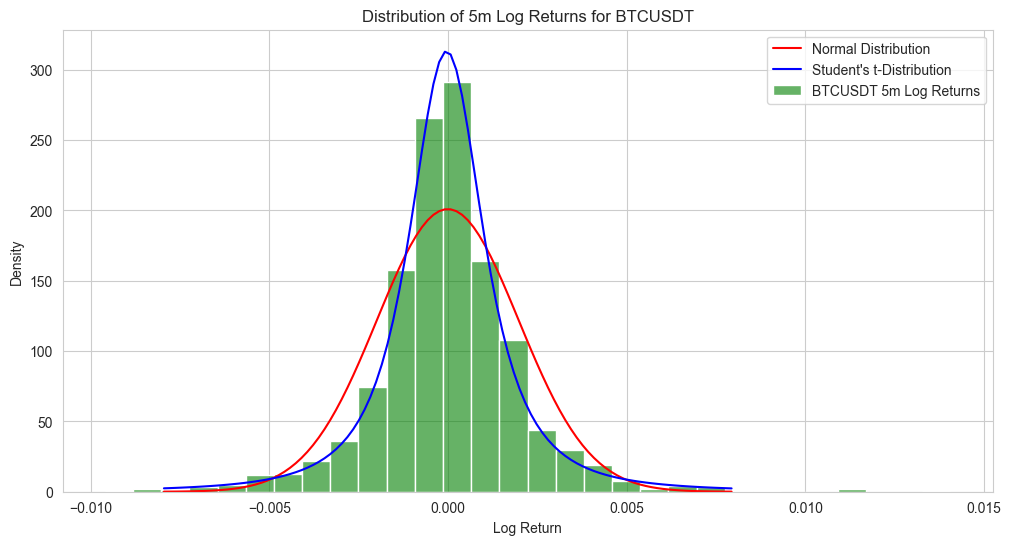

BTCUSDT: normaltest stat = 249.47, p-value = 0.000
=> Distribution significantly differs from a normal distribution.



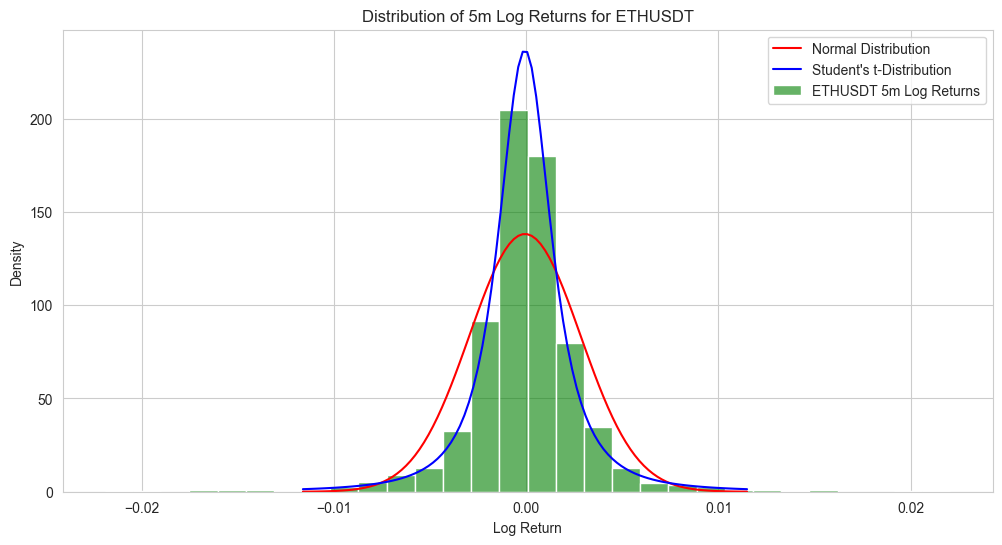

ETHUSDT: normaltest stat = 377.03, p-value = 0.000
=> Distribution significantly differs from a normal distribution.



In [ ]:
# List of selected crypto symbols
selected_symbols = ["SOLUSDT", "ADAUSDT", "BTCUSDT", "ETHUSDT"]

for symbol in selected_symbols:
    df_sym = combined_df[combined_df["Symbol"] == symbol].sort_values("Open time")
    if len(df_sym) < 2:
        continue
    # Calculate log returns
    df_sym["LogReturn"] = np.log(df_sym["Close"] / df_sym["Close"].shift(1))
    returns = df_sym["LogReturn"].dropna()

    # Fit distributions: normal and Student's t
    mu, sigma = returns.mean(), returns.std()
    df_t, loc, scale = stats.t.fit(returns)
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)

    # Plot histogram and fitted distributions
    plt.figure(figsize=(12, 6))
    sns.histplot(returns, bins=30, stat="density", color="green", alpha=0.6, label=f"{symbol} 5m Log Returns")
    plt.plot(x, stats.norm.pdf(x, mu, sigma), "r-", label="Normal Distribution")
    plt.plot(x, stats.t.pdf(x, df_t, loc, scale), "b-", label="Student's t-Distribution")
    plt.title(f"Distribution of 5m Log Returns for {symbol}")
    plt.xlabel("Log Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Normality test
    stat_val, p_val = stats.normaltest(returns)
    print(f"{symbol}: normaltest stat = {stat_val:.2f}, p-value = {p_val:.3f}")
    if p_val < 0.05:
        print("=> Distribution significantly differs from a normal distribution.\n")
    else:
        print("=> Distribution does not significantly differ from a normal distribution.\n")


# Dynamic Portfolio Optimization (Markowitz Sharpe Maximization)

* **Optimize Portfolio Weights:**  
  Calculates optimal asset weights by maximizing the Sharpe ratio using a 30-period rolling window with constraints (sum=1, max weight per asset).

* **Price & Returns:**  
  Aggregates price data from `combined_df` and computes percentage returns.

* **Sliding Window Optimization:**  
  Rebalances every 5 periods and stores weights over time, forward filling missing values.

* **Mapping Weights:**  
  Associates the dynamic optimal weights with each row in `combined_df` based on the "Open time" and "Symbol" columns.


In [ ]:
def optimize_markowitz_sharpe(returns_data, risk_free_rate=0.02, max_weight=0.4):
    mu = returns_data.mean()
    cov = returns_data.cov()
    n = len(returns_data.columns)
    def neg_sharpe(w):
        ret = np.dot(w, mu)
        vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        return -(ret - risk_free_rate) / vol
    cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, max_weight)] * n
    res = minimize(neg_sharpe, np.full(n, 1/n), method='SLSQP', bounds=bounds, constraints=cons)
    return res.x if res.success else np.full(n, 1/n)

# Réorganisation des données de prix
price_df = combined_df.groupby(["Open time", "Symbol"])["Close"].mean().unstack("Symbol").dropna()
print("Aperçu des prix:")
display(price_df.head())

# Calcul des rendements (variation en pourcentage)
returns_df = price_df.pct_change().dropna()
print("Aperçu des rendements:")
display(returns_df.head())

# Optimisation dynamique par fenêtre glissante
window_size = 30      # nombre de périodes pour l'estimation
rebalance_period = 5  # rééquilibrage tous les 5 jours
weights_history = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)
last_rebalance = window_size
current_weights = None

for i in range(window_size, len(returns_df)):
    t = returns_df.index[i]
    if current_weights is None or i >= last_rebalance + rebalance_period:
        window_data = returns_df.iloc[i - window_size:i]
        current_weights = optimize_markowitz_sharpe(window_data)
        last_rebalance = i
    weights_history.loc[t] = current_weights

# Remplissage en avant pour couvrir toutes les dates
weights_ffill = weights_history.reindex(price_df.index, method='ffill')

# Mapping des poids optimaux dans combined_df
def get_optimal_weight(row):
    try:
        return weights_ffill.loc[row["Open time"], row["Symbol"]]
    except KeyError:
        return np.nan

combined_df["optimal_weight"] = combined_df.apply(get_optimal_weight, axis=1)
print("combined_df avec les poids optimaux dynamiques:")
display(combined_df)


Aperçu des prix:


Symbol,ADAUSDT,ALGOUSDT,ATOMUSDT,AVAXUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,ETHUSDT,FILUSDT,ICPUSDT,LINKUSDT,LTCUSDT,SHIBUSDT,SOLUSDT,TRXUSDT,VETUSDT,XLMUSDT,XTZUSDT
Open time,,,,,,,,,,,,,,,,,,,
2025-03-09 09:55:00,0.8008,0.2203,4.047,19.96,583.66,85564.00,0.18803,4.259,2165.79,3.013,5.790,14.95,100.46,0.000013,138.02,0.2410,0.02681,0.2763,0.725
2025-03-09 10:00:00,0.7969,0.2198,4.044,20.01,583.86,85477.95,0.18795,4.253,2165.05,3.007,5.780,14.95,100.72,0.000013,137.85,0.2409,0.02679,0.2748,0.724
2025-03-09 10:05:00,0.7918,0.2193,4.049,20.00,583.27,85444.05,0.18719,4.247,2162.90,3.004,5.777,14.90,100.38,0.000013,137.51,0.2410,0.02667,0.2734,0.723
2025-03-09 10:10:00,0.7884,0.2196,4.051,20.01,582.81,85492.00,0.18765,4.263,2165.50,3.003,5.789,14.93,100.38,0.000013,137.70,0.2411,0.02672,0.2734,0.724
2025-03-09 10:15:00,0.7850,0.2191,4.041,19.90,582.06,85408.00,0.18703,4.253,2159.52,2.996,5.768,14.92,100.09,0.000012,137.35,0.2410,0.02664,0.2732,0.723


Aperçu des rendements:


Symbol,ADAUSDT,ALGOUSDT,ATOMUSDT,AVAXUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,ETHUSDT,FILUSDT,ICPUSDT,LINKUSDT,LTCUSDT,SHIBUSDT,SOLUSDT,TRXUSDT,VETUSDT,XLMUSDT,XTZUSDT
Open time,,,,,,,,,,,,,,,,,,,
2025-03-09 10:00:00,-0.004870,-0.002270,-0.000741,0.002505,0.000343,-0.001006,-0.000425,-0.001409,-0.000342,-0.001991,-0.001727,0.000000,0.002588,0.000799,-0.001232,-0.000415,-0.000746,-0.005429,-0.001379
2025-03-09 10:05:00,-0.006400,-0.002275,0.001236,-0.000500,-0.001011,-0.000397,-0.004044,-0.001411,-0.000993,-0.000998,-0.000519,-0.003344,-0.003376,-0.001597,-0.002466,0.000415,-0.004479,-0.005095,-0.001381
2025-03-09 10:10:00,-0.004294,0.001368,0.000494,0.000500,-0.000789,0.000561,0.002457,0.003767,0.001202,-0.000333,0.002077,0.002013,0.000000,0.000000,0.001382,0.000415,0.001875,0.000000,0.001383
2025-03-09 10:15:00,-0.004313,-0.002277,-0.002469,-0.005497,-0.001287,-0.000983,-0.003304,-0.002346,-0.002761,-0.002331,-0.003628,-0.000670,-0.002889,-0.002400,-0.002542,-0.000415,-0.002994,-0.000732,-0.001381
2025-03-09 10:20:00,0.000892,-0.001369,-0.000495,-0.000503,-0.000206,-0.000388,-0.000214,0.000000,-0.002176,-0.001001,-0.000173,-0.001340,0.001299,-0.000802,-0.001311,0.000415,0.000751,-0.001464,0.000000


combined_df avec les poids optimaux dynamiques:


,Symbol,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,...,Stoch_K,Stoch_D,OBV,News_Title,News_Summary,News_pubDate,News_URL,sentiment_score_tb,sentiment_tb,optimal_weight
0,ETHUSDT,2025-03-09 09:55:00,2168.80000000,2168.80000000,2160.92000000,2165.7900,2253.08540000,1741514399999,4876486.25692400,11795,...,21.248631,19.532676,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre,NaN
1,ETHUSDT,2025-03-09 10:00:00,2165.80000000,2166.70000000,2163.00000000,2165.0500,1379.31240000,1741514699999,2985831.49130800,8586,...,21.248631,19.532676,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre,NaN
2,ETHUSDT,2025-03-09 10:05:00,2165.05000000,2170.30000000,2162.56000000,2162.9000,817.31330000,1741514999999,1771974.33109600,7641,...,21.248631,19.532676,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre,NaN
3,ETHUSDT,2025-03-09 10:10:00,2162.91000000,2166.10000000,2161.67000000,2165.5000,736.47400000,1741515299999,1594066.20442500,6103,...,21.248631,19.532676,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre,NaN
4,ETHUSDT,2025-03-09 10:15:00,2165.50000000,2167.70000000,2157.72000000,2159.5200,1321.80840000,1741515599999,2856838.67510300,7893,...,21.248631,19.532676,-3.576363e+05,Bitcoin price rises as US inflation cools desp...,The uptick comes amid easing US inflation rate...,2025-03-13T10:33:15Z,https://finance.yahoo.com/news/bitcoin-price-u...,0.00,Neutre,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64507,ALGOUSDT,2025-03-16 09:40:00,0.19550000,0.19550000,0.19450000,0.1948,629119.00000000,1742118299999,122614.94950000,855,...,21.428571,20.476190,-1.678290e+07,Young Money: 4 Cryptos Perfect for Millennial ...,Buying cryptos for millennial and Gen-Z invest...,2024-03-21T20:30:00Z,https://finance.yahoo.com/news/young-money-4-c...,0.18,Positif,6.267695e-13
64508,ALGOUSDT,2025-03-16 09:45:00,0.19480000,0.19540000,0.19480000,0.1954,157389.00000000,1742118599999,30710.58240000,436,...,21.428571,20.476190,-1.678290e+07,Young Money: 4 Cryptos Perfect for Millennial ...,Buying cryptos for millennial and Gen-Z invest...,2024-03-21T20:30:00Z,https://finance.yahoo.com/news/young-money-4-c...,0.18,Positif,6.267695e-13
64509,ALGOUSDT,2025-03-16 09:45:00,0.19480000,0.19540000,0.19480000,0.1954,157389.00000000,1742118599999,30710.58240000,436,...,21.428571,20.476190,-1.678290e+07,Young Money: 4 Cryptos Perfect for Millennial ...,Buying cryptos for millennial and Gen-Z invest...,2024-03-21T20:30:00Z,https://finance.yahoo.com/news/young-money-4-c...,0.18,Positif,6.267695e-13
64510,ALGOUSDT,2025-03-16 09:50:00,0.19540000,0.19540000,0.19490000,0.1951,57989.00000000,1742118899999,11314.09720000,192,...,21.428571,20.476190,-1.678290e+07,Young Money: 4 Cryptos Perfect for Millennial ...,Buying cryptos for millennial and Gen-Z invest...,2024-03-21T20:30:00Z,https://finance.yahoo.com/news/young-money-4-c...,0.18,Positif,6.267695e-13


Aperçu du DataFrame 'portfolio_df' :


,portfolio_return,cumulative_return
Open time,,
2025-03-09 12:35:00,0.004475,0.004475
2025-03-09 12:40:00,-0.000288,0.004186
2025-03-09 12:45:00,0.000442,0.00463
2025-03-09 12:50:00,0.000711,0.005344
2025-03-09 12:55:00,0.002,0.007355


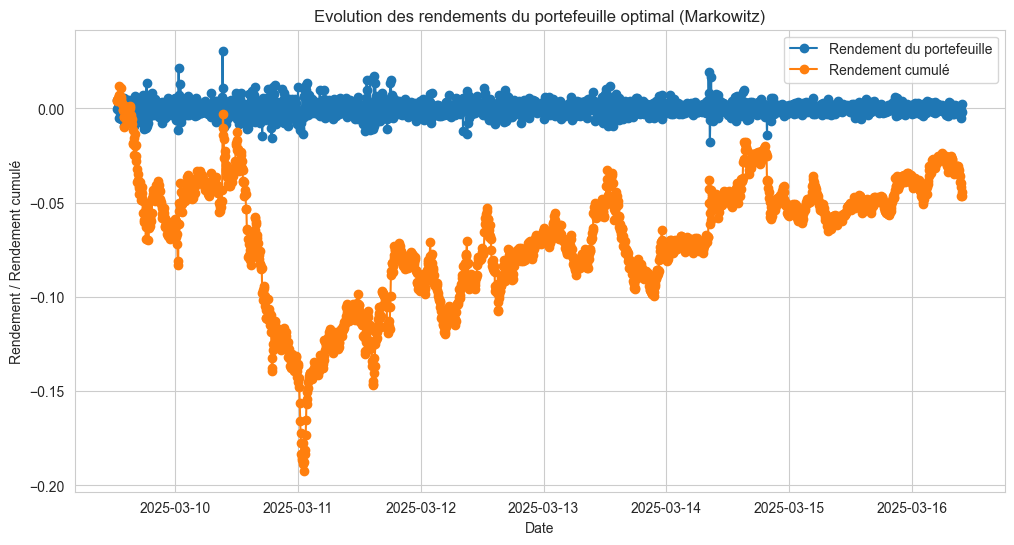

In [ ]:
import matplotlib.pyplot as plt

# ------------------------------
# 1. Calcul des rendements du portefeuille et du rendement cumulé

# Décalage d'une période des poids pour éviter le "look-ahead bias"
weights_shifted = weights_ffill.shift(1).dropna()

# Intersection des index pour s'assurer qu'on ne multiplie que sur des dates communes
common_index = returns_df.index.intersection(weights_shifted.index)

# Calcul du rendement du portefeuille à chaque date
portfolio_returns = (weights_shifted.loc[common_index] * returns_df.loc[common_index]).sum(axis=1)

# Construction d'un DataFrame pour regrouper ces informations
portfolio_df = pd.DataFrame({
    "portfolio_return": portfolio_returns
}, index=common_index)

# Calcul du rendement cumulé (on part de 1 et on multiplie à chaque étape)
portfolio_df["cumulative_return"] = (1 + portfolio_df["portfolio_return"]).cumprod() - 1

# Aperçu du DataFrame
print("Aperçu du DataFrame 'portfolio_df' :")
display(portfolio_df.head())

# ------------------------------
# 2. Tracé des rendements et du rendement cumulé

plt.figure(figsize=(12, 6))

plt.plot(portfolio_df.index, portfolio_df["portfolio_return"], label="Rendement du portefeuille", marker='o')
plt.plot(portfolio_df.index, portfolio_df["cumulative_return"], label="Rendement cumulé", marker='o')

plt.title("Evolution des rendements du portefeuille optimal (Markowitz)")
plt.xlabel("Date")
plt.ylabel("Rendement / Rendement cumulé")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Définir le répertoire et les chemins de fichiers
base_dir = os.path.join(os.path.expanduser("~"), "Desktop", "eric")
os.makedirs(base_dir, exist_ok=True)
combined_csv_file = os.path.join(base_dir, "combined_df.csv")
latest_csv_file = os.path.join(base_dir, "latest_df.csv")

def update_csv(file_path, new_df):
    """
    Lit un fichier CSV existant, fusionne avec new_df, élimine les doublons,
    et sauvegarde le résultat dans file_path.
    """
    if os.path.exists(file_path):
        try:
            existing_df = pd.read_csv(file_path, delimiter=";")
            print(f"Colonnes dans {os.path.basename(file_path)}:", existing_df.columns.tolist())
            if "Open time" not in existing_df.columns and "Open_time" in existing_df.columns:
                existing_df.rename(columns={"Open_time": "Open time"}, inplace=True)
            if "Open time" in existing_df.columns:
                existing_df["Open time"] = pd.to_datetime(existing_df["Open time"])
            updated_df = pd.concat([existing_df, new_df], ignore_index=True)
            updated_df = updated_df.drop_duplicates(subset=["Open time", "Symbol"], keep="last")
        except Exception as e:
            print(f"Erreur lors de la lecture de {os.path.basename(file_path)}: {e}")
            updated_df = new_df.copy()
    else:
        updated_df = new_df.copy()
    updated_df.to_csv(file_path, index=False, sep=";")
    print(f"{os.path.basename(file_path)} mis à jour et sauvegardé dans {file_path}")
    return updated_df

# Mise à jour des fichiers CSV pour combined_df et latest_df
updated_combined = update_csv(combined_csv_file, combined_df)
updated_latest = update_csv(latest_csv_file, latest_df)


Colonnes dans combined_df.csv: ['Symbol,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,SMA10,SMA20,EMA10,EMA20,RSI,MACD,Signal,MACD_Hist,BB_Middle,BB_Upper,BB_Lower,Stoch_K,Stoch_D,OBV,News_Title_x,News_Summary_x,News_pubDate_x,News_URL_x,sentiment_score_tb_x,sentiment_tb_x,News_Title_y,News_Summary_y,News_pubDate_y,News_URL_y,sentiment_score_tb_y,sentiment_tb_y,optimal_weight', 'Unnamed: 1']
combined_df.csv mis à jour et sauvegardé dans /Users/mohameddiagne/Desktop/eric/combined_df.csv
Colonnes dans latest_df.csv: ['Symbol,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,SMA10,SMA20,EMA10,EMA20,RSI,MACD,Signal,MACD_Hist,BB_Middle,BB_Upper,BB_Lower,Stoch_K,Stoch_D,OBV,News_Title_x,News_Summary_x,News_pubDate_x,News_URL_x,sentiment_score_tb_x,sentiment_tb_x,News_Title_y,News_Summary_y,News_